In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
CW_DATASET_PATH = "CW_dataset"

def load_data(dataset_path=CW_DATASET_PATH):
    x_train_all_path = os.path.join(dataset_path, "x_train_all.csv")
    y_train_all_path = os.path.join(dataset_path, "y_train_all.csv")
    x_test_all_path = os.path.join(dataset_path, "x_test_all.csv")
    y_test_all_path = os.path.join(dataset_path, "y_test_all.csv")

    x_train_all = pd.read_csv(x_train_all_path)
    y_train_all = pd.read_csv(y_train_all_path)
    x_test_all = pd.read_csv(x_test_all_path)
    y_test_all = pd.read_csv(y_test_all_path)

    return x_train_all, y_train_all,x_test_all,y_test_all

In [3]:
x_train, y_train,x_test, y_test = load_data()



In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score,cross_val_predict

def calculate_metrics_and_mean(X_train, y_train, y_pred, model):
    report = classification_report(y_train, y_pred, output_dict=True,zero_division=0)
    report_df = pd.DataFrame(report).T.iloc[:-3].drop(columns='support')
    cm = confusion_matrix(y_train, y_pred)
    tp = np.diagonal(cm)
    fn = np.sum(cm, axis=1) - tp
    fp = np.sum(cm, axis=0) - tp
    tn = np.sum(cm) - (tp + fn + fp)
    tp_rate = tp / (tp + fn)
    fp_rate = fp / (fp + tn)
    tp_fp_rate_df = pd.DataFrame({'TPR': tp_rate, 'FPR': fp_rate}, index=range(len(tp_rate)))
    specificity = []
    unique_labels = np.unique(y_train)
    try:
        for i in range(len(unique_labels)):
            true_negative = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
            total_negative = np.sum(cm) - np.sum(cm[i, :])
            specificity.append(true_negative / total_negative)
        specificity_df = pd.DataFrame({'specificity': specificity}, index=unique_labels)
    except:
        specificity_df = pd.DataFrame({'specificity': np.nan}, index=unique_labels)
    try:
        sensitivity = recall_score(y_train, y_pred, average=None)
        sensitivity_df = pd.DataFrame({'sensitivity': sensitivity}, index=unique_labels)
    except:
        sensitivity_df = pd.DataFrame({'sensitivity': np.nan}, index=unique_labels)

    result_df = pd.concat([report_df.reset_index().drop(columns='index'),
                           tp_fp_rate_df.reset_index().drop(columns='index'),
                           specificity_df.reset_index().drop(columns='index'),
                           sensitivity_df.reset_index().drop(columns='index')], axis=1)
    
    try:
        auc = roc_auc_score(y_train, model.predict_proba(X_train), multi_class='ovr')
    except:
        auc = 0
    auc_df = pd.DataFrame({'AUC': auc}, index=unique_labels)
    
    accuracy = accuracy_score(y_train, y_pred)
    accuracy_df = pd.DataFrame({'accuracy': [accuracy]})
    
    try:
        cross_val_scores = cross_val_score(model, X_train, y_train, cv=10)
    except :
        try:
            cross_val_scores = cross_val_predict(model, X_train, y_train, cv=10)
        except:
            cross_val_scores = [0]

    cross_val_mean = np.mean(cross_val_scores)
    cross_val_std = np.std(cross_val_scores)
    cross_val_df = pd.DataFrame({'CV mean': [cross_val_mean], 'CV std': [cross_val_std]})

    result_df = pd.concat([result_df, auc_df, accuracy_df, cross_val_df], axis=1)
    mean_values = pd.DataFrame(result_df.mean()).transpose()
    mean_values.index = ['mean']
    result_df = pd.concat([result_df, mean_values])
    
    return result_df

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

def plot_multiclass_roc_curve(dt, x_test, y_test, resolution=199):
    probabilities_dt = dt.predict_proba(x_test)
    roc_auc_scores_dt = []

    plt.figure(figsize=(8, 6))
    unique_labels_dt = np.unique(y_train)

    for i in range(len(unique_labels_dt)):
        fpr_dt, tpr_dt, _ = roc_curve((y_test == unique_labels_dt[i]).astype(int), probabilities_dt[:, i])
        roc_auc_dt = auc(fpr_dt, tpr_dt)
        roc_auc_scores_dt.append(roc_auc_dt)

        # Increase the resolution for smoother curves
        fpr_interp = np.interp(np.linspace(0, 1, resolution), fpr_dt, tpr_dt)
        plt.plot(np.linspace(0, 1, resolution), fpr_interp, lw=2, label=f'ROC curve (class {unique_labels_dt[i]}, area = {roc_auc_dt:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) for Multiclass Decision Tree')
    plt.legend(loc='lower right')
    plt.show()

In [6]:
from sklearn.tree import DecisionTreeClassifier,plot_tree

dt = DecisionTreeClassifier(max_depth=17,criterion='entropy',random_state=42)
dt.fit(x_train, y_train) 

DecisionTreeClassifier(criterion='entropy', max_depth=17, random_state=42)

[Text(0.4564554080638175, 0.96875, 'x[1264] <= 84.5\nentropy = 2.773\nsamples = 9690\nvalue = [210, 2220, 2250, 1410, 1980, 210, 360, 240, 540, 270]'),
 Text(0.24820253844210222, 0.90625, 'x[1696] <= 63.5\nentropy = 2.839\nsamples = 4098\nvalue = [11, 336, 451, 1183, 931, 149, 338, 168, 321, 210]'),
 Text(0.10428661023678891, 0.84375, 'x[983] <= 38.5\nentropy = 2.338\nsamples = 3029\nvalue = [3, 311, 384, 1070, 920, 55, 170, 12, 85, 19]'),
 Text(0.03645682933872365, 0.78125, 'x[1265] <= 30.5\nentropy = 1.647\nsamples = 1084\nvalue = [0, 43, 63, 224, 686, 30, 33, 1, 4, 0]'),
 Text(0.017037250938492638, 0.71875, 'x[982] <= 18.5\nentropy = 1.763\nsamples = 448\nvalue = [0, 6, 3, 208, 165, 30, 33, 0, 3, 0]'),
 Text(0.0051978053710655505, 0.65625, 'x[1169] <= 11.5\nentropy = 1.158\nsamples = 209\nvalue = [0, 1, 0, 22, 155, 29, 2, 0, 0, 0]'),
 Text(0.002310135720473578, 0.59375, 'x[300] <= 12.0\nentropy = 0.79\nsamples = 38\nvalue = [0, 0, 0, 9, 0, 29, 0, 0, 0, 0]'),
 Text(0.0011550678602367

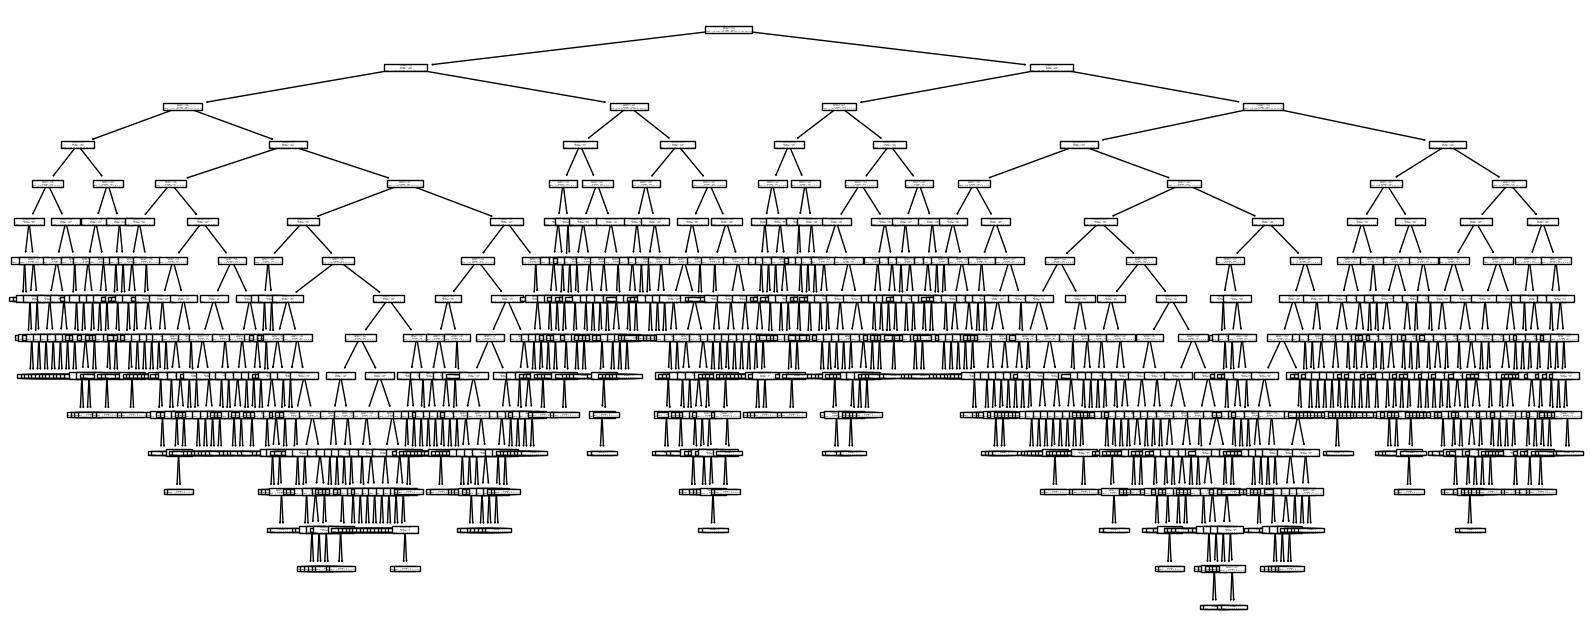

In [7]:
plt.figure(figsize=(20, 8))
plot_tree(dt)

In [8]:
y_pred = dt.predict(x_test)

calculate_metrics_and_mean(x_test, y_test, y_pred, dt)

,precision,recall,f1-score,TPR,FPR,specificity,sensitivity,AUC,accuracy,CV mean,CV std
0,0.412500,0.550000,0.471429,0.550000,0.015512,0.984488,0.550000,0.796454,0.726861,0.8411,0.016275
1,0.720050,0.793056,0.754792,0.793056,0.093671,0.906329,0.793056,0.796454,NaN,NaN,NaN
2,0.768309,0.769333,0.768821,0.769333,0.074359,0.925641,0.769333,0.796454,NaN,NaN,NaN
3,0.737705,0.700000,0.718358,0.700000,0.042424,0.957576,0.700000,0.796454,NaN,NaN,NaN
4,0.825083,0.757576,0.789889,0.757576,0.043621,0.956379,0.757576,0.796454,NaN,NaN,NaN
5,0.814815,0.733333,0.771930,0.733333,0.003300,0.996700,0.733333,0.796454,NaN,NaN,NaN
6,0.505376,0.522222,0.513661,0.522222,0.015333,0.984667,0.522222,0.796454,NaN,NaN,NaN
7,0.531250,0.283333,0.369565,0.283333,0.004950,0.995050,0.283333,0.796454,NaN,NaN,NaN
8,0.631579,0.640000,0.635762,0.640000,0.019048,0.980952,0.640000,0.796454,NaN,NaN,NaN
9,0.450980,0.511111,0.479167,0.511111,0.018667,0.981333,0.511111,0.796454,NaN,NaN,NaN


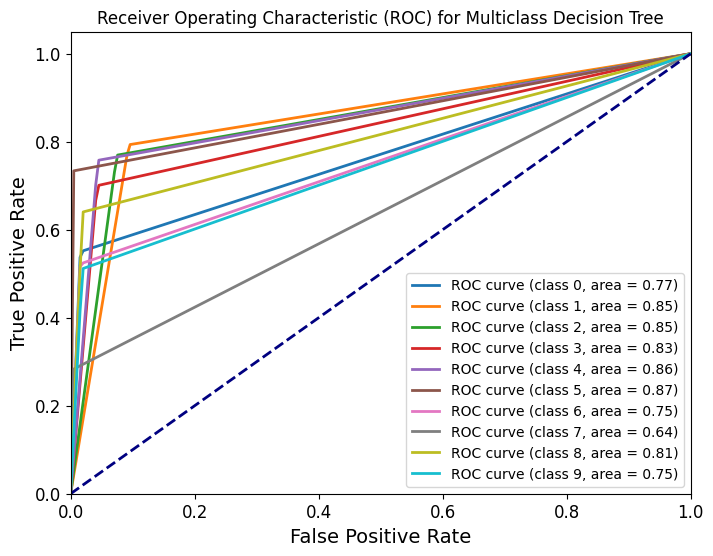

In [9]:
plot_multiclass_roc_curve (dt, x_test, y_test)

Ref: https://colab.research.google.com/drive/1a7ZfYvTSju41AXrEX5570-dFT8zGwVpH?usp=sharing#scrollTo=EPFvRB2v6J4H

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
x_test_pca = pca.fit_transform(x_test)
x_train_pca = pca.fit_transform(x_train)

In [11]:
from sklearn.tree import DecisionTreeClassifier,plot_tree

dt_pca = DecisionTreeClassifier(max_depth=17,criterion='entropy',random_state=42)
dt_pca.fit(x_train_pca, y_train) 

DecisionTreeClassifier(criterion='entropy', max_depth=17, random_state=42)

In [12]:
y_pred = dt_pca.predict(x_test_pca)

calculate_metrics_and_mean(x_test_pca, y_test, y_pred, dt)

c:\Users\ishaq\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


,precision,recall,f1-score,TPR,FPR,specificity,sensitivity,AUC,accuracy,CV mean,CV std
0,0.024691,0.033333,0.028369,0.033333,0.026073,0.973927,0.033333,0.0,0.243042,0.555663,0.031973
1,0.349582,0.348611,0.349096,0.348611,0.197046,0.802954,0.348611,0.0,NaN,NaN,NaN
2,0.300268,0.298667,0.299465,0.298667,0.223077,0.776923,0.298667,0.0,NaN,NaN,NaN
3,0.220339,0.202222,0.210892,0.202222,0.121970,0.878030,0.202222,0.0,NaN,NaN,NaN
4,0.266323,0.234848,0.249597,0.234848,0.175720,0.824280,0.234848,0.0,NaN,NaN,NaN
5,0.000000,0.000000,0.000000,0.000000,0.024752,0.975248,0.000000,0.0,NaN,NaN,NaN
6,0.070707,0.077778,0.074074,0.077778,0.030667,0.969333,0.077778,0.0,NaN,NaN,NaN
7,0.011494,0.016667,0.013605,0.016667,0.028383,0.971617,0.016667,0.0,NaN,NaN,NaN
8,0.060302,0.080000,0.068768,0.080000,0.063605,0.936395,0.080000,0.0,NaN,NaN,NaN
9,0.088889,0.088889,0.088889,0.088889,0.027333,0.972667,0.088889,0.0,NaN,NaN,NaN


[Text(0.35154537582502055, 0.9722222222222222, 'x[0] <= -1739.553\nentropy = 2.773\nsamples = 9690\nvalue = [210, 2220, 2250, 1410, 1980, 210, 360, 240, 540, 270]'),
 Text(0.06546308155381321, 0.9166666666666666, 'x[0] <= -3103.085\nentropy = 2.524\nsamples = 2551\nvalue = [0, 184, 368, 710, 830, 70, 202, 41, 115, 31]'),
 Text(0.00604199036415151, 0.8611111111111112, 'x[0] <= -3490.647\nentropy = 1.764\nsamples = 427\nvalue = [0, 13, 2, 81, 256, 30, 38, 0, 7, 0]'),
 Text(0.0014623509903510948, 0.8055555555555556, 'x[1] <= 694.476\nentropy = 0.958\nsamples = 79\nvalue = [0, 0, 0, 0, 49, 30, 0, 0, 0, 0]'),
 Text(0.001253443706015224, 0.75, 'entropy = 0.0\nsamples = 30\nvalue = [0, 0, 0, 0, 30, 0, 0, 0, 0, 0]'),
 Text(0.0016712582746869656, 0.75, 'x[1] <= 731.982\nentropy = 0.963\nsamples = 49\nvalue = [0, 0, 0, 0, 19, 30, 0, 0, 0, 0]'),
 Text(0.0014623509903510948, 0.6944444444444444, 'x[0] <= -3584.07\nentropy = 0.779\nsamples = 39\nvalue = [0, 0, 0, 0, 9, 30, 0, 0, 0, 0]'),
 Text(0.001

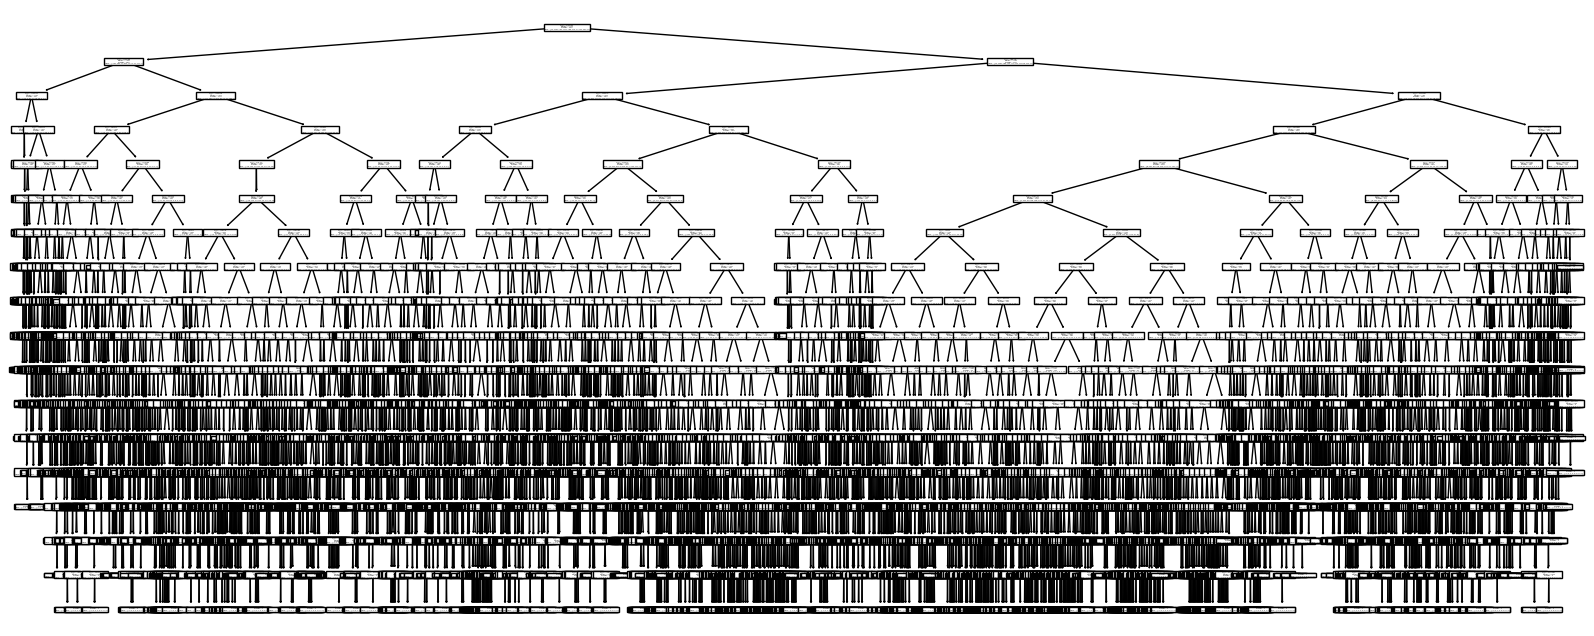

In [13]:
plt.figure(figsize=(20, 8))
plot_tree(dt_pca)

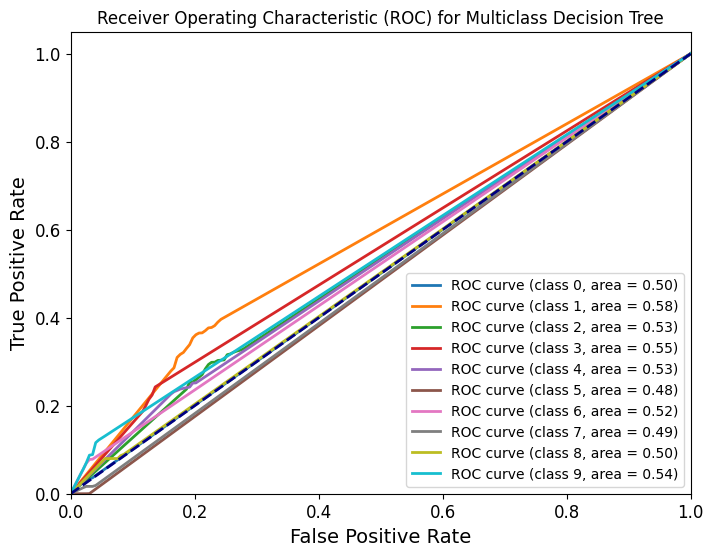

In [14]:
plot_multiclass_roc_curve (dt_pca, x_test_pca, y_test)